In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!unzip drive/My\ Drive/ammi-2020-convnets.zip 
# !mkdir models
# !cp -r drive/My\ Drive/data/models/* models/.


# !cp -r models/* drive/My\ Drive/data/models/.

Streaming output truncated to the last 5000 lines.
  inflating: train/train/cbsd/train-cbsd-117.jpg  
  inflating: train/train/cbsd/train-cbsd-1170.jpg  
  inflating: train/train/cbsd/train-cbsd-1171.jpg  
  inflating: train/train/cbsd/train-cbsd-1172.jpg  
  inflating: train/train/cbsd/train-cbsd-1173.jpg  
  inflating: train/train/cbsd/train-cbsd-1174.jpg  
  inflating: train/train/cbsd/train-cbsd-1175.jpg  
  inflating: train/train/cbsd/train-cbsd-1176.jpg  
  inflating: train/train/cbsd/train-cbsd-1177.jpg  
  inflating: train/train/cbsd/train-cbsd-1178.jpg  
  inflating: train/train/cbsd/train-cbsd-1179.jpg  
  inflating: train/train/cbsd/train-cbsd-118.jpg  
  inflating: train/train/cbsd/train-cbsd-1180.jpg  
  inflating: train/train/cbsd/train-cbsd-1181.jpg  
  inflating: train/train/cbsd/train-cbsd-1182.jpg  
  inflating: train/train/cbsd/train-cbsd-1183.jpg  
  inflating: train/train/cbsd/train-cbsd-1184.jpg  
  inflating: train/train/cbsd/train-cbsd-1185.jpg  
  inflating: tr

In [3]:
!pip install pretrainedmodels
!pip install optuna

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=c4561240ae65119e76b36a683380ab652c7408d4c038217c5d177243348e6c29
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 7.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 112kB 16.8MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=4a14f1ba591323d0890ff3a9af070e22aca

In [4]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch.nn.functional as F
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import pretrainedmodels
import os
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import numpy as np
import pandas as pd
import os
import datetime as dt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models



%matplotlib inline

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


In [0]:
data_path = "train/train/"
test_path = "test/test/0"
extraimage_path = "extraimages/extraimages"

In [6]:
print('Train set:')
class_distrbution = {}
for cls in os.listdir(data_path):
    print('{}:{}'.format(cls, len(os.listdir(os.path.join(data_path, cls)))))
    class_distrbution[cls] =  len(os.listdir(os.path.join(data_path, cls)))
im = Image.open(data_path+'/cgm/train-cgm-738.jpg')
print(im.size)
class_distrbution

Train set:
cmd:2658
healthy:316
cgm:773
cbb:466
cbsd:1443
(500, 500)


{'cbb': 466, 'cbsd': 1443, 'cgm': 773, 'cmd': 2658, 'healthy': 316}

In [0]:
# Transformations for both the training and testing data
mean=[0.4543, 0.5137, 0.3240]
std=[0.1949, 0.1977, 0.1661]


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(331), #448, 299, 224, 331
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

test_transforms = transforms.Compose([ transforms.Resize(331),
                                       transforms.CenterCrop(331),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

# normalize = transforms.Normalize(mean=mean, std=std)

In [0]:


class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        class_names = {}
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])

                name = str(i)+'-'+className
                if name not in class_names:
                    class_names[name] = 1
                else:
                    class_names[name] += 1
        self.file_list = files
        print(class_names)
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        
# #         return im.view(3, 448, 448), classCategory
#         return im.view(3, 224, 224), classCategory
# #         return im.view(3, 299, 299), classCategory
        return im.view(3, 331, 331), classCategory   # NASNetLarge 331x331

In [9]:
train_data = CassavaDataset(data_path, transform=train_transforms)

test_data = CassavaDataset(test_path, transform=test_transforms)

extraimage_data = CassavaDataset(extraimage_path, transform=train_transforms) #maybe need an other trasforms, I had to change the dataset structure :)

{'0-cmd': 2658, '1-healthy': 316, '2-cgm': 773, '3-cbb': 466, '4-cbsd': 1443}
{}
{}


In [0]:
# from torch.utils.data.sampler import SubsetRandomSampler

# validation_split = 0.2
# shuffle_dataset = True
# random_seed= 42

# # Creating data indices for training and validation splits:
# dataset_size = len(train_data)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))

# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)

# train_indices, val_indices = indices[split:], indices[:split]

# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)


# train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
#                                              sampler=train_sampler)
# valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
#                                              sampler=valid_sampler)

# test_loader = torch.utils.data.DataLoader(test_data, batch_size=1) 

In [0]:
# valid_sampler = SubsetRandomSampler(val_indices)
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
#-----------------------------------------------------------------------------z

validation_split = 0.2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]


targets=[]
data=[]
file_list = train_data.file_list
np.random.shuffle(file_list)
for i in file_list:
    targets.append(i[0])
    data.append(i[2])
    
target_train=targets[split:]
train_set=data[split:]

target_test=targets[:split]
test_set=data[:split]

class_count = np.unique(target_train ,return_counts=True)[1]
class_count_test= np.unique(target_test, return_counts=True)[1]


#--------------------------------------------------------------------
# get weights train

weight_train = 1. / class_count
samples_weight_train = weight_train[target_train]
samples_weight_train = torch.from_numpy(samples_weight_train)
sampler_train = WeightedRandomSampler(samples_weight_train, len(samples_weight_train))

#### valid
weight_test = 1. / class_count_test
samples_weight_test = weight_test[target_test]

samples_weight_test = torch.from_numpy(samples_weight_test)
sampler_valid = WeightedRandomSampler(samples_weight_test, len(samples_weight_test))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                             sampler=sampler_train)


valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                             sampler=sampler_valid)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)

In [12]:
from collections import Counter,OrderedDict
for i,(image,label) in enumerate(valid_loader):
    print(Counter(label.numpy()))
    if i==5:
        break
        
train_loader.dataset.classes

Counter({4: 17, 3: 16, 0: 12, 1: 11, 2: 8})
Counter({0: 18, 4: 14, 1: 13, 2: 11, 3: 8})
Counter({2: 20, 0: 13, 1: 12, 3: 12, 4: 7})
Counter({3: 15, 4: 13, 2: 13, 0: 12, 1: 11})
Counter({4: 16, 0: 15, 3: 13, 2: 12, 1: 8})
Counter({2: 15, 4: 15, 0: 14, 3: 12, 1: 8})


['cmd', 'healthy', 'cgm', 'cbb', 'cbsd']

In [0]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4, 0, 2, 0, 0, 0, 4, 2, 0, 0, 0, 0, 4, 3, 2, 0, 3, 0, 0, 2, 4, 0, 3, 0,
        1, 0, 3, 4, 2, 4, 3, 0, 0, 0, 4, 1, 4, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 4, 2, 3, 0, 4, 0, 0, 1, 0, 4, 4, 2])


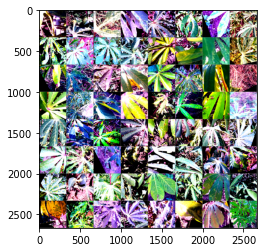

In [16]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(labels)
img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

In [0]:

class Additional(nn.Module):
    def __init__(self, modelA,in_features,nb_classes=5,drop=0.1):
        super(Additional, self).__init__()
        self.modelA = modelA
        # Remove last linear layer
        self.modelA.last_linear = nn.Identity()
        
        for p in self.modelA.parameters():
            p.requires_grad = False
        
        # Create new classifier
        self.fc_1 = nn.Linear(51200,1024)
        self.fc_2 = nn.Linear(1024,  512)
        self.fc_out = nn.Linear( 512, nb_classes)
        
        #Dropout
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        #model
        x = self.modelA(x)  
        x = x.view(x.size(0), -1)
        
        #FC
        x  = self.dropout(F.relu(self.fc_1(x)))
        x = self.dropout(F.relu(self.fc_2(x)))
        x = self.fc_out(x)
        
        return x

In [0]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch,device):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
#         print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        # if (i + 1) % 100 == 0:
        #     print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
        #         epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
        #     total_loss_train.append(train_loss.avg)
        #     total_acc_train.append(train_acc.avg)
            
            
        
    return train_loss.avg, train_acc.avg

In [0]:
def validate(val_loader, model, criterion, optimizer, epoch,device):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    # print('------------------------------------------------------------')
    # print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    # print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [0]:
def test(test_loader,train_loader, model):
    model.eval()
    pred = []
    _class_labels = np.array(train_loader.dataset.classes)
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, _ = data
            images = Variable(images).to(device)
    
            outputs = model(images)
    
            prediction = outputs.data.cpu().numpy().argmax()
            
            _predicted_class_labels = _class_labels[prediction]
            
            pred.append(_predicted_class_labels)

    return pred

In [0]:
def objective(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    drop  = trial.suggest_loguniform('drop', 0.1, 0.5)

    model = pretrainedmodels.se_resnext50_32x4d(num_classes=1000, pretrained="imagenet")
    model_name = 'se_resnext50_32x4d'

    model = Additional(model,model.last_linear.in_features,drop=drop)
    model = model.to(device)
    
    class_weights = [class_distrbution[i] for i in train_loader.dataset.classes]
    class_weights_normalized = [max(class_weights)/i for i in class_weights]

    class_weights_normalized,torch.Tensor(class_weights_normalized)

    weights = torch.Tensor(class_weights_normalized)
    weights = weights.to(device)
    
    lr  = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    optim_ = trial.suggest_categorical('optim_',[optim.Adam])
    momentum = trial.suggest_uniform('momentum', 0.4, 0.99)
    optimizer = optim_(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss(weight = weights)
    
    epoch_num = 5
    best_val_acc = 0.85
    total_loss_val, total_acc_val = [],[]
    for epoch in range(1, epoch_num+1):
        loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch,device)
        loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch,device)
        total_loss_val.append(loss_val)
        total_acc_val.append(acc_val)
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
        print('*****************************************************')
        print('best record: [epoch %d], [Train loss %.5f], [Train acc %.5f], [val loss %.5f], [val acc %.5f]' % (epoch,loss_train,acc_train, loss_val, acc_val))
        print('*****************************************************')
            
     # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
            
    return acc_val

In [0]:
import optuna

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(func=objective, n_trials=20)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/checkpoints/se_resnext50_32x4d-a260b3a4.pth


/usr/local/lib/python3.6/dist-packages/optuna/distributions.py:316: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.

[W 2020-05-07 10:57:24,780] Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.


*****************************************************
best record: [epoch 1], [Train loss 3020.97241], [Train acc 0.18990], [val loss 29.70849], [val acc 0.19216]
*****************************************************
*****************************************************
best record: [epoch 2], [Train loss 56.72912], [Train acc 0.13968], [val loss 3.02712], [val acc 0.21386]
*****************************************************
*****************************************************
best record: [epoch 3], [Train loss 5.44229], [Train acc 0.30441], [val loss 3.69611], [val acc 0.20520]
*****************************************************
*****************************************************
best record: [epoch 4], [Train loss 2.18304], [Train acc 0.11437], [val loss 1.58767], [val acc 0.20135]
*****************************************************


[I 2020-05-07 11:05:32,844] Finished trial#0 with value: 0.19393976098191212 with parameters: {'drop': 0.18903086609659467, 'lr': 0.08325505752117665, 'optim_': <class 'torch.optim.adam.Adam'>, 'momentum': 0.6829708923960192}. Best is trial#0 with value: 0.19393976098191212.


*****************************************************
best record: [epoch 5], [Train loss 2.79719], [Train acc 0.12074], [val loss 2.42840], [val acc 0.19394]
*****************************************************


[W 2020-05-07 11:05:33,536] Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.


*****************************************************
best record: [epoch 1], [Train loss 1.32569], [Train acc 0.54623], [val loss 0.77735], [val acc 0.70759]
*****************************************************
*****************************************************
best record: [epoch 2], [Train loss 0.88034], [Train acc 0.67142], [val loss 0.79890], [val acc 0.68766]
*****************************************************
*****************************************************
best record: [epoch 3], [Train loss 0.76076], [Train acc 0.71298], [val loss 0.71006], [val acc 0.74836]
*****************************************************
*****************************************************
best record: [epoch 4], [Train loss 0.69174], [Train acc 0.74942], [val loss 0.66629], [val acc 0.75662]
*****************************************************


[I 2020-05-07 11:13:40,608] Finished trial#1 with value: 0.7319121447028424 with parameters: {'drop': 0.22718094258849195, 'lr': 0.0006035926194171829, 'optim_': <class 'torch.optim.adam.Adam'>, 'momentum': 0.4954605591869628}. Best is trial#1 with value: 0.7319121447028424.


*****************************************************
best record: [epoch 5], [Train loss 0.69994], [Train acc 0.73797], [val loss 0.60493], [val acc 0.73191]
*****************************************************


[W 2020-05-07 11:13:41,231] Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.


*****************************************************
best record: [epoch 1], [Train loss 1.19282], [Train acc 0.56016], [val loss 0.87157], [val acc 0.68245]
*****************************************************
*****************************************************
best record: [epoch 2], [Train loss 0.77846], [Train acc 0.70390], [val loss 0.63220], [val acc 0.74398]
*****************************************************
*****************************************************
best record: [epoch 3], [Train loss 0.76097], [Train acc 0.71898], [val loss 0.80700], [val acc 0.74663]
*****************************************************
*****************************************************
best record: [epoch 4], [Train loss 0.69301], [Train acc 0.74360], [val loss 0.75420], [val acc 0.72842]
*****************************************************


[I 2020-05-07 11:21:51,068] Finished trial#2 with value: 0.7761426033591731 with parameters: {'drop': 0.30756437088105715, 'lr': 0.00031735991316969835, 'optim_': <class 'torch.optim.adam.Adam'>, 'momentum': 0.5053992367955688}. Best is trial#2 with value: 0.7761426033591731.


*****************************************************
best record: [epoch 5], [Train loss 0.63891], [Train acc 0.75198], [val loss 0.53824], [val acc 0.77614]
*****************************************************


[W 2020-05-07 11:21:51,700] Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.


*****************************************************
best record: [epoch 1], [Train loss 145.53710], [Train acc 0.12767], [val loss 3.09370], [val acc 0.19172]
*****************************************************
*****************************************************
best record: [epoch 2], [Train loss 1.83611], [Train acc 0.15250], [val loss 1.62015], [val acc 0.19174]
*****************************************************
*****************************************************
best record: [epoch 3], [Train loss 1.61408], [Train acc 0.13544], [val loss 1.67700], [val acc 0.19913]
*****************************************************
*****************************************************
best record: [epoch 4], [Train loss 1.79247], [Train acc 0.19314], [val loss 2.47286], [val acc 0.17089]
*****************************************************


[I 2020-05-07 11:30:03,715] Finished trial#3 with value: 0.18441133720930233 with parameters: {'drop': 0.2657519823805395, 'lr': 0.021268566046401798, 'optim_': <class 'torch.optim.adam.Adam'>, 'momentum': 0.40573428465612565}. Best is trial#2 with value: 0.7761426033591731.


*****************************************************
best record: [epoch 5], [Train loss 1.63452], [Train acc 0.14933], [val loss 1.60357], [val acc 0.18441]
*****************************************************


[W 2020-05-07 11:30:04,363] Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.


*****************************************************
best record: [epoch 1], [Train loss 15.64300], [Train acc 0.26676], [val loss 0.99966], [val acc 0.46814]
*****************************************************
*****************************************************
best record: [epoch 2], [Train loss 1.37529], [Train acc 0.35841], [val loss 1.22553], [val acc 0.40346]
*****************************************************
*****************************************************
best record: [epoch 3], [Train loss 1.32907], [Train acc 0.39938], [val loss 0.94480], [val acc 0.47505]
*****************************************************
*****************************************************
best record: [epoch 4], [Train loss 1.29011], [Train acc 0.34268], [val loss 1.12690], [val acc 0.46641]
*****************************************************


[I 2020-05-07 11:38:13,166] Finished trial#4 with value: 0.49109738372093026 with parameters: {'drop': 0.20054389269259318, 'lr': 0.007016955451992863, 'optim_': <class 'torch.optim.adam.Adam'>, 'momentum': 0.7068640648647624}. Best is trial#2 with value: 0.7761426033591731.


*****************************************************
best record: [epoch 5], [Train loss 1.31651], [Train acc 0.29208], [val loss 1.12471], [val acc 0.49110]
*****************************************************


[W 2020-05-07 11:38:13,793] Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.


*****************************************************
best record: [epoch 1], [Train loss 1.03983], [Train acc 0.60776], [val loss 0.83142], [val acc 0.69152]
*****************************************************
*****************************************************
best record: [epoch 2], [Train loss 0.79914], [Train acc 0.71923], [val loss 0.68329], [val acc 0.72796]
*****************************************************
*****************************************************
best record: [epoch 3], [Train loss 0.78432], [Train acc 0.70748], [val loss 0.62975], [val acc 0.75703]
*****************************************************
*****************************************************
best record: [epoch 4], [Train loss 0.70201], [Train acc 0.74590], [val loss 0.84444], [val acc 0.73888]
*****************************************************


[I 2020-05-07 11:46:25,202] Finished trial#5 with value: 0.7782622739018088 with parameters: {'drop': 0.33667563083166335, 'lr': 8.618421423167725e-05, 'optim_': <class 'torch.optim.adam.Adam'>, 'momentum': 0.7702235211405812}. Best is trial#5 with value: 0.7782622739018088.


*****************************************************
best record: [epoch 5], [Train loss 0.63903], [Train acc 0.75570], [val loss 0.64135], [val acc 0.77826]
*****************************************************


[W 2020-05-07 11:46:25,831] Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.


*****************************************************
best record: [epoch 1], [Train loss 1.26375], [Train acc 0.53131], [val loss 0.73589], [val acc 0.63774]
*****************************************************


In [0]:
# {'drop': 0.45960061928495244, 'lr': 0.0003055895273264541, 'optim_': <class 'torch.optim.adam.Adam'>, 'momentum': 0.854037402574283}. Best is trial#2 with value: 0.7509891795865633.

## Sumission

In [0]:
class_names = {0:'cbsd', 1: 'cgm', 2: 'cbb', 3: 'healthy', 4: 'cmd'}

In [0]:
def process_image(image_dir):
    # Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    image = Image.open(image_dir)
    preprocess = transforms.Compose([ transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])
    image = preprocess(image)
    # Convert 2D image to 1D vector
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)
    inputs = image.to(device)
    return inputs

In [0]:
# Using our model to predict the label
def predict(image, model):
    # Pass the image through our model
    output = model(image)
    # Reverse the log function in our output
    output = torch.exp(output)
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [0]:
test_directory = "./data/test/test/0"
predictions, test_image_fileName = [], []
try:
    test_images = listdir(test_directory)
    for images in test_images:
        test_image_fileName.append(images)
        image = process_image(f'{test_directory}/{images}')
        top_prob, top_class = predict(image, model)
        predictions.append(class_names[top_class])
except Exception as e:
    print(e)

In [0]:
print("[INFO] Creating pandas dataframe")
submission_data = {"Category":predictions,"Id":test_image_fileName,}
submission_data_frame = pd.DataFrame(submission_data)

In [0]:
submission_data_frame.head()

In [0]:
submission_data_frame.to_csv('submission'+model_name+'_freeze_86_flip.csv', header=True, index=False)